Il codice nella cella seguente **deve essere eseguito**, ma **non deve essere modificato**, perché essenziale per un'esecuzione senza errori del successivo codice del laboratorio. Dopo averlo eseguito, attendi che scompaia il simbolo [*] o che il pallino adiacente ad R in alto a destra diventi bianco

In [1]:
#Esegui ma non modificare. Attendi  che scompaia il simbolo [*] 
#o che il pallino adiacente ad R in alto a destra diventi bianco
#potrebbe essere necessario qualche minuto
source('lib/preamble.R')

# Introduzione

Abbiamo visto che la regressione multipla soffre di problemi come l'overfitting e la multicollinearità.
L'overfitting è un problema che si presenta nei casi in cui il numero di osservazioni è piccolo rispetto al numero di predittori, spesso si dice "small $n$, big $p$", quindi bassa dimensione campionaria ($n$) e alta dimensionalità ($p$). 
Questo si traduce solitamente in stime dei coefficienti di regressione meno stabili, perché i tanti parametri da stimare si adattano eccessivamente ai pochi dati disponibili e la modifica di una sola osservazione può cambiare totalmente tali stime.
Anche il problema della multicollinearità dei predittori si traduce in stime del modello basate sul metodo dei minimi quadrati poco stabili. In caso di elevata correlazione tra gruppi di covariate, le varianze degli stimatori dei coefficienti di regressione corrispondenti risultano essere artificialmente elevate.

I metodi di selezione delle variabili, che abbiamo visto nella lezione precedente, affrontano questo problema riducendo il numero di variabili. L'idea è che, se il numero di covariate è troppo elevato, la selezione riduce questo numero, risolvendo il problema dell'eccessivo adattamento, mentre se ci sono gruppi di variabili fortemente correlate, la selezione rimuove variabili da questi gruppi facendo sì che l'insieme di covariate che resta nel modello non soffra più di questo problema di collinearità.

# Metodi per la riduzione della dimensionalità
Se ci rifletti, e forse ti sarà già venuto in mente, hai già a disposizione un metodo capace di eliminare la multicollinearità tra i predittori: applicare la PCA alla matrice dei dati contenente le osservazioni dei predittori, ed applicare la regressione lineare multipla tra la variabile di risposta e la matrice degli score da cui abbiamo cancellato le ultime colonne, relative alle ultime componenti principali, ispezionando lo scree plot.

## Regressione con le componenti principali (Principal component regression, PCR)

La regressione con le componenti principali, detta anche in inglese *Principal component regression* (PCR) risolve non solo il problema di multicollinearità tra i regressori, ma riducendo il numero di predittori, tende a risolvere anche i problemi di overfitting.
Nello specifico, ricorderai che le componenti principali (PC) sono ortogonali tra loro e ciò si riflette nella matrice degli score (ricorda la matrice `pr.out$x`) che ha, per costruzione, colonne tra di loro ortogonali.

Scegliendo dallo screeplot il numero adeguato, che indichiamo con $M$, di PC da considerare nel modello si ottiene un nuovo set di covariate a media nulla, tra loro incorrelate, che non soffrono del problema di multicollinearità. 

Inoltre, scegliendo un numero $M$ piccolo rispetto al numero $p$ di covariate disponibili, si ottiene una riduzione della dimensionalità che consente di mitigare anche eventuali problemi dell'overfitting, qualora la dimensione campionaria $n$ fosse piccola rispetto a $p$. 
Nota, però, che troncare il numero di componenti principali a $M$ per la PCR, non equivale a selezionare variabili, nel senso che non viene mantenuto il significato fisico delle variabili iniziali. Tuttavia se le PC sono suscettibili di interpretazione (per esempio quando le frecce dei loading si dispongono a croce sul biplot) questo non costituisce un grave problema. 
Quindi il problema della scelta del numero di componenti $M$, risulta cruciale nella PCR. 
A tale scopo, per migliorare la capacità predittiva della PCR, e non solo quella descrittiva della PCA, invece dello scree plot, spesso $M$ viene selezionato attraverso cross-validation.

In `R` tutto ciò è molto immediato ed automatico.
La PCR si appoggia alla funzione `pcr()` del pacchetto `pls`. 
La cross-validation può essere implementata nella stessa funzione, utilizzando l'argomento `validation = "LOO"`, che in particolare esegue la leave-one-out cross-validation.
Come nella PCA è utile standardizzare la matrice dei dati utilizzando l'argomento `scale = TRUE` prima di effettuare la PCR.
Purtoppo però, anche i coefficienti di regressione restituiti alla fine non saranno nella scala originale delle covariate, ma riferiti alla matrice standardizzata dei dati, contenente le osservazioni dei predittori iniziali.

Consideriamo il data set `Hitters` disponibile attraverso il pacchetto `ISLR` e rimuoviamo le righe con dati mancanti come di seguito.

In [2]:
library(ISLR)
data(Hitters)
df <- na.omit(Hitters)

Definiamo un insieme di dati (75%) per il training ed uno (25%) per il test.

In [3]:
set.seed(1)
train <- sample(1:nrow(df), size = nrow(df) * .75)
df.train <- df[train, ]
df.test <- df[- train, ]

Applichiamo la funzione `pcr()` al data set `Hitters`, indicando, come al solito la variabile `Salary` come variabile di risposta.

In [4]:
library(pls)

set.seed(1)
pcr.fit <- pcr(Salary ~ ., data = df.train, scale = TRUE, validation = "LOO")

Scegliamo quindi il numero di componenti $M$ che minimizza l'errore quadratico medio di previsione `MSEP` e salviamolo in `pcr.ncomp`.

[1] 6

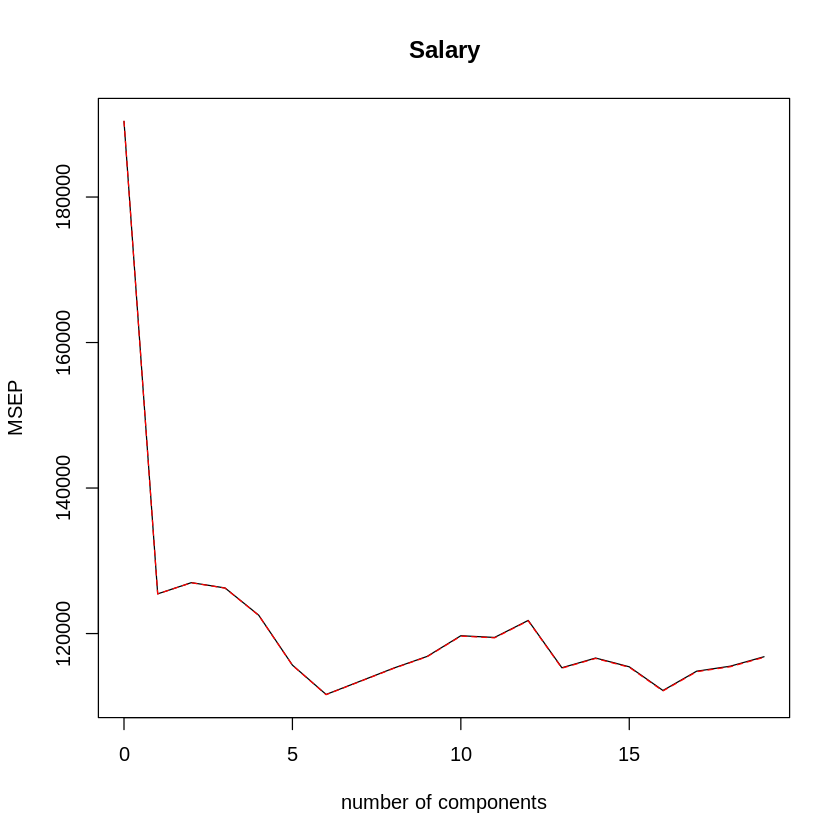

In [5]:
validationplot(pcr.fit, val.type = "MSEP")
pcr.ncomp <- which.min(pcr.fit$validation$PRESS)
pcr.ncomp %>% round(2)

Calcoliamo anche, solo per un eventuale motivo di confronto con altri modelli, il valore quadratico medio `pcr.MSE` dell'errore di previsione *out-of-sample* sul test set `df.test` in corrispondenza di `pcr.ncomp`.

In [6]:
pcr.pred <- predict(pcr.fit, df.test, ncomp = pcr.ncomp)
y.test <- df.test$Salary
pcr.MSE <- mean((pcr.pred-y.test) ^ 2)
pcr.MSE  %>% round

[1] 138380

Calcoliamo i coefficienti di regressione riferiti al modello di regressione lineare multipla completo iniziale, che tuttavia, come anticipato, sono riferiti alla matrice standardizzata dei dati, contenente le osservazioni dei predittori iniziali. Tale modello ha la seguente struttura

$$\hat y = \hat \beta_0 + \hat \beta_1 \frac{x_{i1}-\bar x_1}{s_1} + \hat \beta_2 \frac{x_{i2}-\bar x_2}{s_2}  +...$$


In [7]:
pcr.fit <- pcr(Salary ~ ., data = df, scale = TRUE, validation = "LOO")
pcr.coef <- pcr.fit$coefficients[, , pcr.ncomp]
pcr.coef  %>% round(2)

AtBat       Hits      HmRun       Runs        RBI      Walks      Years 
     24.36      25.32      16.52      24.48      26.86      33.87      24.42 
    CAtBat      CHits     CHmRun      CRuns       CRBI     CWalks    LeagueN 
     30.53      31.62      27.46      32.50      31.83      33.61      10.91 
 DivisionW    PutOuts    Assists     Errors NewLeagueN 
    -68.87      74.95      -3.33       3.19      11.96

## Metodi di regolarizzazione (shrinkage)

Un approccio alternativo alla PCR è quello dei **metodi di regolarizzazione**, che, invece di cercare il miglior sottoinsieme di variabili tra quelle disponibili, si focalizzano sul problema dell'instabilità delle stime ottenute mediante il metodo dei minimi quadrati. L'instabilità, come già ribadito più volte, è legata all'elevata incertezza della stima del modello, quantificata mediante la deviazione standard degli stimatori dei coefficienti di regressione, o all'ampiezza dei corrispondenti intervalli di confidenza, a causa della multicollinearità dei predittori e/o overfitting del modello ai dati. 

I metodi di regolarizzazione considerano un modello con tutti i predittori disponibili, ma aggiungono, con lo scopo di penalizzare valori troppo elevati del vettore dei coefficienti di regressione, alla funzione obiettivo (utilizzata nel metodo dei minimi quadrati) una quantità pari al prodotto di un termine di penalizzazione $P$ e un parametro, detto *parametro di penalità*, $\lambda$.

$$
\sum_{i=1}^n (y_i - \beta_0 - x_{i1} \beta_1- x_{ip} \beta_p)^2 + \lambda P.
$$
Nota che l'intercetta $\beta_0$ non viene penalizzata. Due sono le scelte più diffuse per $P$ 

* la somma dei quadrati dei coefficienti di regressione, ossia $P=\sum_{j=1}^p \beta_j^2$ (**Regressione ridge**)
* la somma dei valori assoluti dei coefficienti di regressione, ossia $P=\sum_{j=1}^p |\beta_j|^2$ (**Regressione LASSO**).

In entrambi i casi, l'idea è che la stima debba rappresentare un buon compromesso tra

* la flessibilità del modello, cioè quanto il modello si adatti ai dati, quindi quanto sia in grado di minimizzare gli errori di previsione in-sample, e contemporaneamente
* la stabilità delle stime.

Questo compromesso è controllato dal parametro di penalità $\lambda$. Maggiore è $\lambda$, maggiore è l'importanza del termine di penalità rispetto ai minimi quadrati.
Nei casi limite:

* $\lambda=0$, il termine di penalità non ha alcun peso e il risultato è analogo a quello ottenuto con la regressione lineare multipla (metodo dei minimi quadrati);
* $\lambda \to \infty$, il termine di penalità diventa l'unico che conta. In questo caso la soluzione ottima è banalmente quella che pone pari a zero tutti i coefficienti di regressione $\beta_j$.

Chiaramente, il parametro $\lambda$ deve essere scelto opportunamente e gioca il ruolo cruciale come $M$ nella PCR.
Spesso questi extra-parametri vengono chiamati *iperparametri*.
In questo corso, mostriamo come scegliere $\lambda$ utilizzando la cross-validation. 
In particolare, il pacchetto `glmnet` fornisce tutte le funzioni necessarie all'implementazione dei metodi di regressione ridge e LASSO e per scegliere il parametro $\lambda$ mediante cross-validation.

### Differenza tra ridge e LASSO

La scelta del termine di penalità ha delle implicazioni nella stima che possono guidare la scelta del metodo da utilizzare. Senza entrare nei dettagli matematici:

* il vantaggio della regressione ridge è che, dato il parametro $\lambda$, la stima dei coefficienti di regressione può essere ottenuta in forma chiusa, mentre la regressione LASSO richiede metodi numerici per trovare la soluzione del problema di ottimizzazione, che inevitabilmente rallenta la computazione quando il data set da analizzare è molto grande
* il vantaggio della regressione LASSO è che il tipo di penalità consente nella maggior parte dei casi, di ottenere stime dei coefficienti di regressione pari esattamente a zero per alcune variabili, consentendo di fatto, una selezione automatica delle variabili. LASSO è infatti l'acronimo di *least absolute shrinkage and selection operator*. La regressione ridge purtroppo all'aumentare della penalità contrae le stime dei coefficienti verso zero, senza ottenere, a meno di rari controesempi strumentali, esattamente zero.


### Motivazione dei termini *regolarizzazione* e *shrinkage* (opzionale)

Nota che l'obiettivo dei metodi di regressione è minimizzare il **mean squared error** (MSE) della stima dei coefficienti, che si può decomporre nella somma di due termini, la distorsione, o *bias* (al quadrato) e la varianza:
$$
MSE(\hat\beta)=bias(\hat\beta)^2+Var(\hat\beta)= [E(\hat\beta - \beta)]^2 + E[(\hat\beta - E(\hat\beta))^2]
$$

Nella regressione multipla, gli stimatori dei coefficienti di regressione ottenuti col metodo dei minimi quadrati sono detti corretti o *unbiased*, in quanto la loro distorsione si può dimostrare essere pari a zero. Inoltre, per un famoso teorema, il Teorema di Gauss-Markov, gli stimatori dei minimi quadrati sono, tra gli stimatori *unbiased*, anche quelli a minima varianza, e quindi, nella classe degli stimatori "unbiased", quelli che raggiungono il minore MSE.

Tuttavia, come più volte ribadito, a causa di overfitting e multicollinearità la varianza di tali stime può diventare troppo elevata e problematica.

I metodi di regolarizzazione, grazie al termine di penalità tentano di "regolarizzare" la stima dei coefficienti di regressione ottenuta col metodo dei minimi quadrati. In altri termini, accettano la presenza di un termine piccolo di distorsione diverso da zero, ma sperano in tal modo di ridurre di molto la varianza degli stimatori, e quindi ottenere complessivamente un MSE minore rispetto al caso precedente.

E' possibile infatti dimostrare che il termine di penalità introduce una distorsione dovuta alla penalizzazione che "contrae" (shrinkage significa contrazione) le stime dei coefficienti di regressione verso lo zero. Maggiore è l'importanza del termine di penalità, data dal parametro $\lambda$, maggiore è il bias, ma minore è la varianza, perché le stime diventano più stabili avvicinandosi a zero.

Vediamo di seguito come implementare facilmente in R i metodi di regressione ridge e LASSO attraverso il pacchetto R `glmnet`.



## Metodi di regolarizzazione in R

Di default `standardize=TRUE` effettua i calcoli standardizzando tutte le variabili (covariate), quindi rendendo l'analisi adimensionale, indipendente dalle unità di misura. Per comodità di interpretazione tuttavia i coefficienti del modello vengono restituiti nell'unità di misura originale delle variabili considerate.

La funzione `glmnet()` richiede in input delle matrici e non dei data frame, come avviene di solito per la funzione `lm()`. Estraiamo gli argomenti richiesti dalla funzione `glmnet()`:

In [8]:
x <- model.matrix(Salary ~ ., df)[, -1] 
y <- df$Salary
x.train <- x[train, ]
x.test <- x[- train, ]
y.train <- y[train]
y.test <- y[- train]

Prima di mostrare come scegliere il parametro di penalità, osserva che è possibile fornire alla funzione `glmnet()`, tramite l'argomento `lambda`, un vettore di valori del parametro di penalità

In [9]:
grid <- 10^seq(10, -2, length.out = 100)

A ognuno di essi, verrà associata la stima corrispondente dei coefficienti di regressione.

Nella funzione `glmnet()`, l'argomento `alpha` è utilizzato per indicare se si desidera scegliere la regressione ridge o LASSO:

* regressione ridge: `alpha = 0`,
* regressione LASSO: `alpha = 1`.

### Regressione ridge
Stima un modello di regressione ridge per ogni valore del parametro di penalizzazione `lambda` contenuto in `grid`. Ottieni quindi un oggetto di classe `'elnet'` o `'glmnet'`.

In [10]:
#Regressione ridge
library(glmnet)
ridge.fit <- glmnet(x, y, alpha = 0, lambda = grid)
class(ridge.fit)

[1] "elnet"  "glmnet"

La funzione `coef()` applicata a `ridge.fit` restituisce una matrice 20x100 contenente su ogni riga i 20 coefficienti di regressione ottenuti per ognuno dei 100 valori di `grid`, che ora sono contenuti anche in `ridge.fit$lambda` 

In [11]:
dim(coef(ridge.fit))
length(ridge.fit$lambda)

[1]  20 100

[1] 100

Puoi quindi stampare, per esempio, in corrispondenza del cinquantesimo valore della griglia di esplorazione di `ridge.fit$lambda` pari a 

In [12]:
ridge.fit$lambda[50] %>% round()

[1] 11498

la stima dei coefficienti. Ovviamente ci aspettiamo che più è grande $\lambda$, maggiore sarà la penalità e più piccole saranno le stime dei coefficienti.

In [13]:
coef(ridge.fit)[, 50] %>% round(2)

(Intercept)       AtBat        Hits       HmRun        Runs         RBI 
     407.36        0.04        0.14        0.52        0.23        0.24 
      Walks       Years      CAtBat       CHits      CHmRun       CRuns 
       0.29        1.11        0.00        0.01        0.09        0.02 
       CRBI      CWalks     LeagueN   DivisionW     PutOuts     Assists 
       0.02        0.03        0.09       -6.22        0.02        0.00 
     Errors  NewLeagueN 
      -0.02        0.30

Possiamo anche ottenere il valore della funzione obiettivo in corrispondenza di tale valore di $\lambda$.

In [14]:
sqrt(sum(coef(ridge.fit)[-1, 50]^2)) %>% round(2)

[1] 6.36

La stessa cosa puoi fare in corrispondenza di un valore minore di $\lambda$. Per esempio

In [15]:
ridge.fit$lambda[70]

[1] 43.28761

Essendo minore del precedente, ci aspettiamo stime più grandi dei coefficienti di regressione.

In [16]:
coef(ridge.fit)[, 70] %>% round(2)

(Intercept)       AtBat        Hits       HmRun        Runs         RBI 
      54.97       -0.41        2.11       -1.35        1.13        0.79 
      Walks       Years      CAtBat       CHits      CHmRun       CRuns 
       2.84       -6.86        0.00        0.11        0.64        0.23 
       CRBI      CWalks     LeagueN   DivisionW     PutOuts     Assists 
       0.23       -0.17       47.59     -119.53        0.25        0.13 
     Errors  NewLeagueN 
      -3.38      -11.37

con un valore della funzione obiettivo pari a 

In [17]:
sqrt(sum(coef(ridge.fit)[- 1, 70] ^ 2)) %>% round(2)

[1] 129.45

Puoi usare la funzione `predict()` per esempio per ottenere i coefficienti ad un valore di $\lambda$ specificato dall'argomento `s=`. Per esempio

In [18]:
predict(ridge.fit, s = ridge.fit$lambda[70], type = "coefficients")[1:20, ] %>% round(2)

(Intercept)       AtBat        Hits       HmRun        Runs         RBI 
      54.97       -0.41        2.11       -1.35        1.13        0.79 
      Walks       Years      CAtBat       CHits      CHmRun       CRuns 
       2.84       -6.86        0.00        0.11        0.64        0.23 
       CRBI      CWalks     LeagueN   DivisionW     PutOuts     Assists 
       0.23       -0.17       47.59     -119.53        0.25        0.13 
     Errors  NewLeagueN 
      -3.38      -11.37

o un nuovo valore, per esempio $\lambda=100$.

In [19]:
predict(ridge.fit, s = 100, type = "coefficients")[1:20, ] %>% round(2)

(Intercept)       AtBat        Hits       HmRun        Runs         RBI 
      21.25       -0.11        1.39       -0.71        1.16        0.85 
      Walks       Years      CAtBat       CHits      CHmRun       CRuns 
       2.19       -2.86        0.01        0.08        0.54        0.17 
       CRBI      CWalks     LeagueN   DivisionW     PutOuts     Assists 
       0.18       -0.04       36.77     -108.66        0.23        0.08 
     Errors  NewLeagueN 
      -2.63        0.01

Adesso, consideriamo i valori dei predittori `x.train` e `x.test `, e delle variabili di risposta `y.train` e `y.test`, contenute nel train e test set, rispettivamente. 
Stimiamo quindi il modello sul train set

In [20]:
ridge.fit <- glmnet(x.train, y.train, alpha = 0, lambda = grid)

e calcoliamo una previsione in corrispondenza di $\lambda=4$ sul test set (usando l'argomento `newx=`) e salvando il risultato nella variabile `ridge.pred`.

In [21]:
ridge.pred <- predict(ridge.fit, s = 4, newx = x.test)

Puoi quindi calcolare il valore di MSE sul test set mediante l'istruzione

In [22]:
mean((ridge.pred - y.test) ^ 2) %>% round(2)

[1] 137668.6

Per confronto, possiamo calcolare l'errore MSE che avremmo avuto sul train set, utilizzando come previsione $\bar y$, ossia `mean(y.train)`.

In [23]:
mean((mean(y.train) - y.test) ^ 2) %>% round(2)

[1] 245980.9

che possiamo anche chiamare *modello con la sola intercetta*, che è proprio il modello che otterrei in corrispondenza di un valore di $\lambda$ elevato, per esempio $\lambda=1e10$.)

In [24]:
ridge.pred <- predict(ridge.fit, s = 1e10, newx = x.test) 
mean((ridge.pred-y.test) ^ 2)  %>% round(2)

[1] 245980.8

Il modello di regressione lineare multipla lo puoi ottenere invece impostando $\lambda=0$.

In [25]:
ridge.pred <- predict(ridge.fit, s = 0, newx = x.test)
mean((ridge.pred-y.test) ^ 2)
predict(ridge.fit, s = 0, type = "coefficients")[1:20, ] %>% round(2)

[1] 142446.4

(Intercept)       AtBat        Hits       HmRun        Runs         RBI 
     263.53       -1.38        4.38        0.41       -3.01        2.06 
      Walks       Years      CAtBat       CHits      CHmRun       CRuns 
       4.93      -20.99       -0.20        0.95       -0.28        0.45 
       CRBI      CWalks     LeagueN   DivisionW     PutOuts     Assists 
       0.45       -0.36      113.27     -162.12        0.38        0.35 
     Errors  NewLeagueN 
      -4.62      -92.67

Ogni curva del seguente grafico mostra come ogni singolo coefficiente viene compresso verso lo zero, in funzione di $\lambda$ in scala logaritmica.

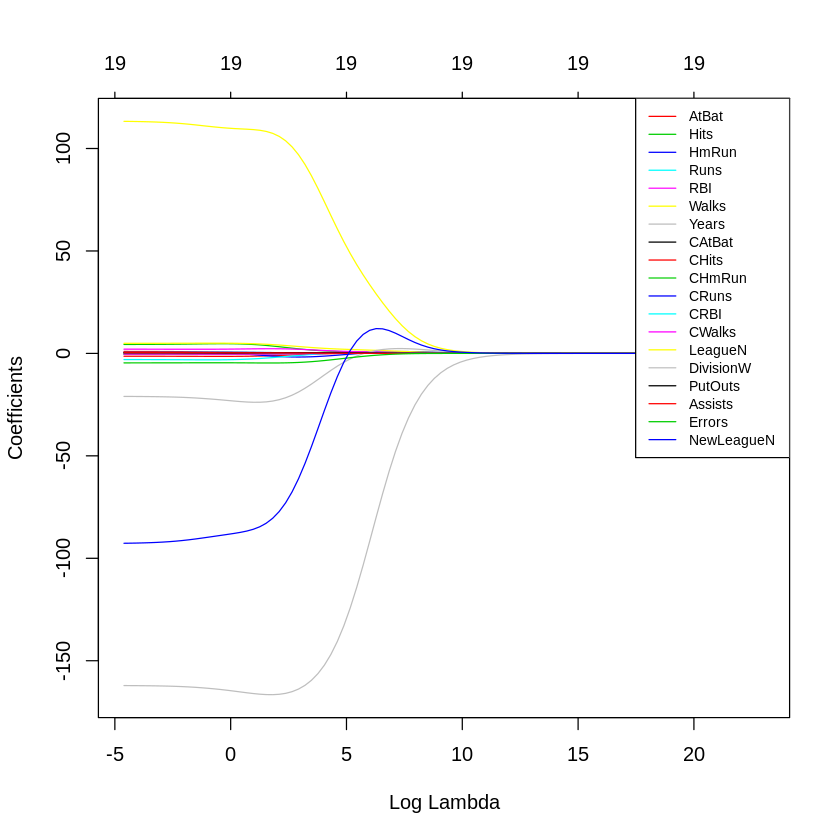

In [26]:
plot(ridge.fit, xvar = "lambda", col = 2:21)
legend("topright", lwd = 1, col = 2:21, legend = colnames(x.test), cex = .7)

Per selezionare il $lambda$ ottimo utilizzeremo, come anticipato, la tecnica di
#### Cross-Validation (CV)
Di default si hanno $k=10$ gruppi (fold). Altrimenti usa l'argomento `nfolds`.

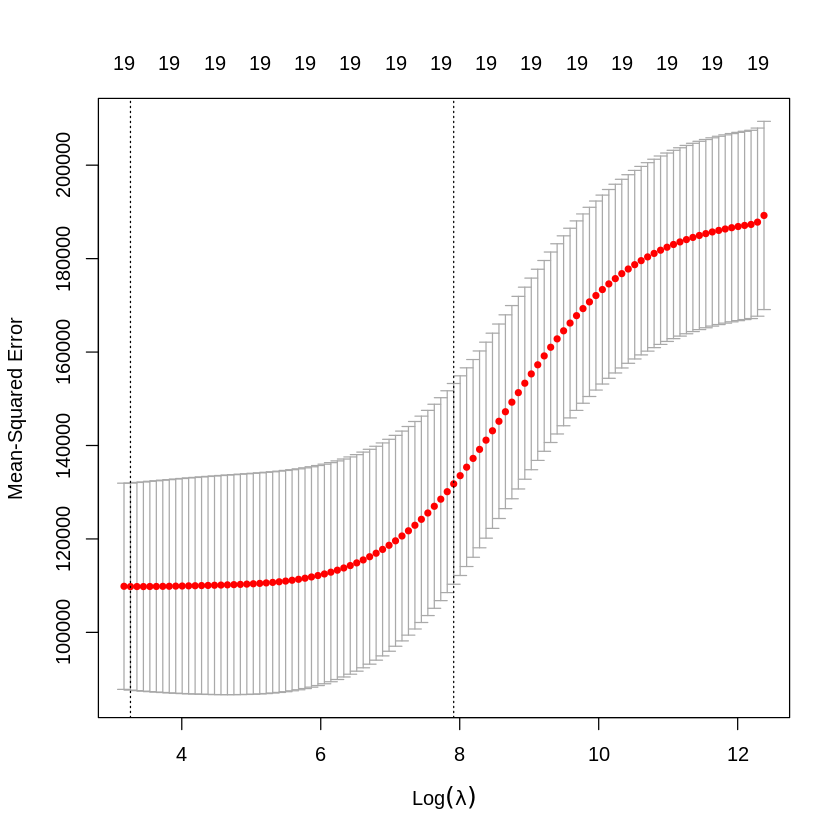

In [27]:
set.seed(1)
cv.out <- cv.glmnet(x.train, y.train, alpha = 0) 
plot(cv.out)

Attraverso le seguenti istruzioni, puoi 

* ottenere il $\lambda$ ottimo 

In [28]:
bestlam <- cv.out$lambda.min; bestlam  %>% round(2)

[1] 26.09

* calcolare il valore MSE su test set

In [29]:
ridge.pred <- predict(ridge.fit, s = bestlam, newx = x.test)
ridge.MSE <- mean((ridge.pred - y.test) ^ 2); ridge.MSE %>% round(2)

[1] 135951.7

A questo punto, puoi finalmente ottenere la stima del modello sul data set completo, in corrispondenza di `s = bestlam` così ottenuto.

In [30]:
ridge.fit <- glmnet(x, y, alpha = 0)
ridge.coef <- predict(ridge.fit, type = "coefficients", s = bestlam)[1:20, ]
ridge.coef %>% round(2)

(Intercept)       AtBat        Hits       HmRun        Runs         RBI 
      80.07       -0.67        2.74       -1.37        1.02        0.72 
      Walks       Years      CAtBat       CHits      CHmRun       CRuns 
       3.36       -8.99        0.00        0.14        0.70        0.29 
       CRBI      CWalks     LeagueN   DivisionW     PutOuts     Assists 
       0.26       -0.27       53.01     -122.74        0.26        0.17 
     Errors  NewLeagueN 
      -3.68      -17.86

Osserva che nessuno dei coefficienti è nullo!

### Regressione LASSO 

Il codice è analogo alla regressione ridge, con `alpha = 1`.

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”


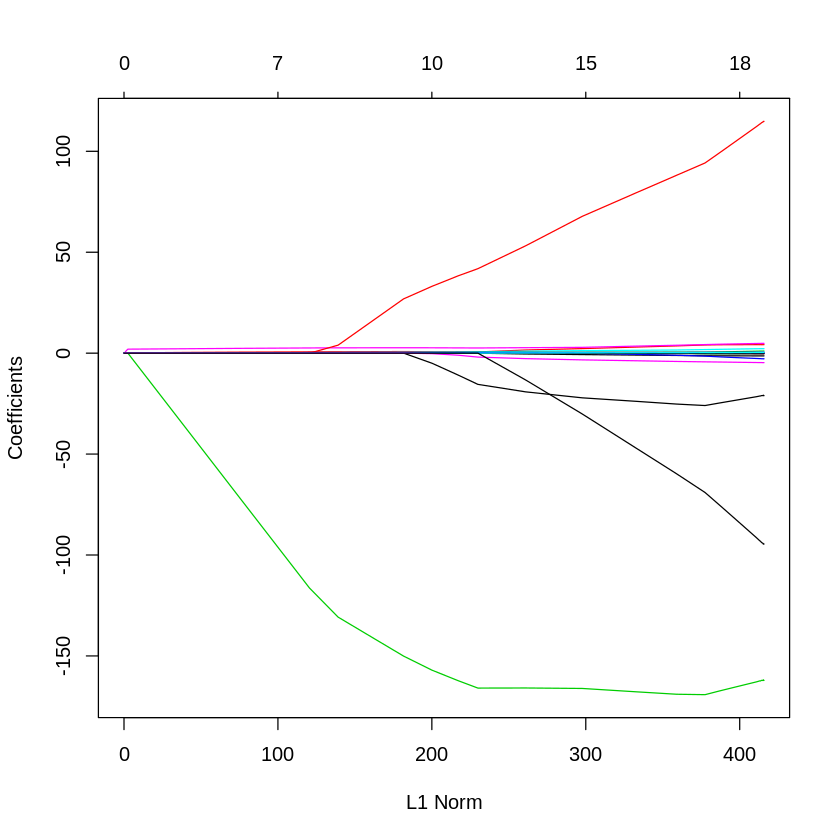

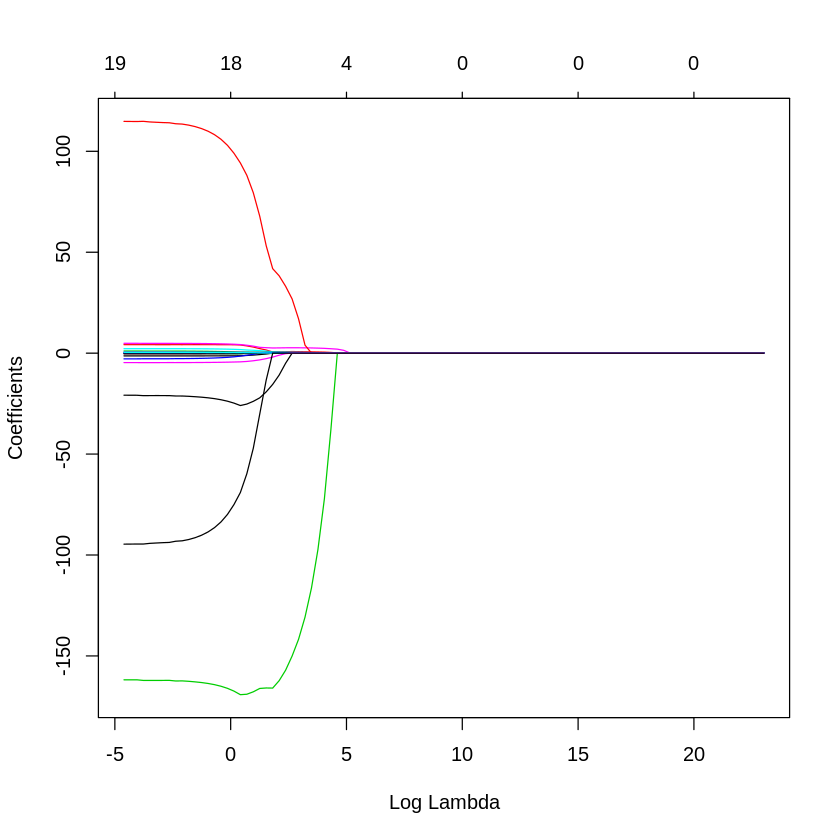

In [31]:
#LASSO
lasso.fit <- glmnet(x.train, y.train, alpha = 1, lambda = grid)
plot(lasso.fit)
plot(lasso.fit, xvar = "lambda")

Dai grafici precedenti si evince che, aumentando il valore del parametro di penalità, da un certo punto in poi le stime dei coefficienti sono "contratte" esattamente a zero.

[1] 135112.5

(Intercept)       AtBat        Hits       HmRun        Runs         RBI 
      16.14        0.00        1.88        0.00        0.00        0.00 
      Walks       Years      CAtBat       CHits      CHmRun       CRuns 
       2.23        0.00        0.00        0.00        0.00        0.21 
       CRBI      CWalks     LeagueN   DivisionW     PutOuts     Assists 
       0.41        0.00        4.55     -104.87        0.22        0.00 
     Errors  NewLeagueN 
       0.00        0.00

(Intercept)        Hits       Walks       CRuns        CRBI     LeagueN 
      16.14        1.88        2.23        0.21        0.41        4.55 
  DivisionW     PutOuts 
    -104.87        0.22

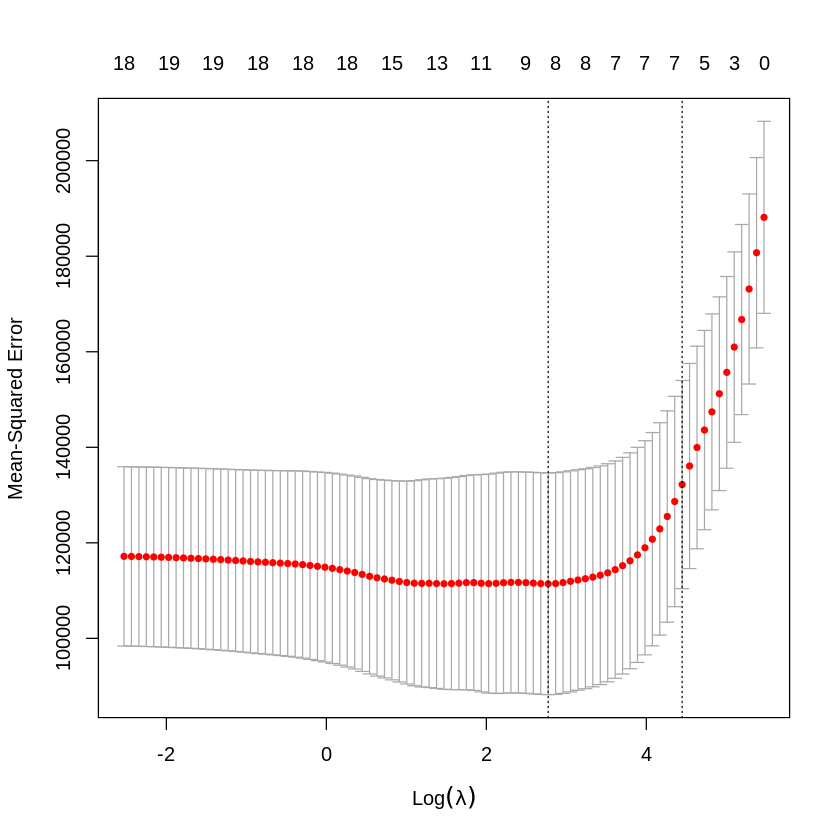

In [32]:
set.seed(1)
cv.out <- cv.glmnet(x.train, y.train, alpha = 1)
plot(cv.out)
bestlam <- cv.out$lambda.min
lasso.pred <- predict(lasso.fit, s = bestlam, newx = x.test)
lasso.MSE <- mean((lasso.pred - y.test) ^ 2)
lasso.MSE %>% round(2)
lasso.fit <- glmnet(x, y, alpha = 1, lambda = grid)
lasso.coef <- predict(lasso.fit, type = "coefficients", s = bestlam)[1:20, ]
lasso.coef  %>% round(2)
lasso.coef[lasso.coef != 0] %>% round(2)

# Confronta i diversi metodi!

Per poter confrontare i differenti metodi, è conveniente riferirsi alle variabili standardizzate.
Tuttavia, i metodi di regressione ridge e LASSO, implementati secondo i pacchetti presentati finora, restituiscono coefficienti nell'unità di misura iniziale delle variabili, mentre la PCR restituisce i coefficienti adimensionali, i.e., in frazioni di deviazione standard.
Pertanto, al fine di ottenere coefficienti confrontabili, è necessario standardizzare manualmente le variabili, e calcolare il MSE sul test set.

In [33]:
x.scaled.train <- scale(x.train)
y.scaled.train <- scale(y.train)
x.scaled.test <- scale(x.test, 
                       center = attr(x.scaled.train, "scaled:center"),
                       scale = attr(x.scaled.train, "scaled:scale"))
y.scaled.test <- scale(y.test, 
                       center = attr(y.scaled.train, "scaled:center"),
                       scale = attr(y.scaled.train, "scaled:scale"))
df.scaled.train <- data.frame(Salary = y.scaled.train,
                              x.scaled.train)
df.scaled.test <- data.frame(Salary = y.scaled.test,
                              x.scaled.test)

## Regressione lineare multipla

In [34]:
lm.fit <- lm(Salary ~ ., data = df.scaled.train)
lm.pred <- predict(lm.fit, df.scaled.test)
lm.MSE <- mean((lm.pred-y.scaled.test) ^ 2)
lm.coef <- coef(lm.fit)[- 1]

#Best subset selection 
library(leaps)
bsub.fit <- regsubsets(Salary~.,data=df.scaled.train,nvmax=19) #nvmax è 8 di default
reg.summary <- summary(bsub.fit)

Come nella lezione precedente definiamo la funzione `predict.regsubsets`.

In [35]:
#possono essere omessi i dettagli per la definizione della seguente funzione
predict.regsubsets <- function(object,newdata,id,...){
  form <- as.formula(object$call[[2]])
  mat <- model.matrix(form,newdata)
  coefi <- coef(object,id=id)
  xvars <- names(coefi)
  mat[,xvars]%*%coefi
}

Per confrontare i diversi modelli, stimiamo l'errore di previsione in-sample e selezioniamo il modello che minimizza $Cp$ o $AIC$

[1] 0.8478696

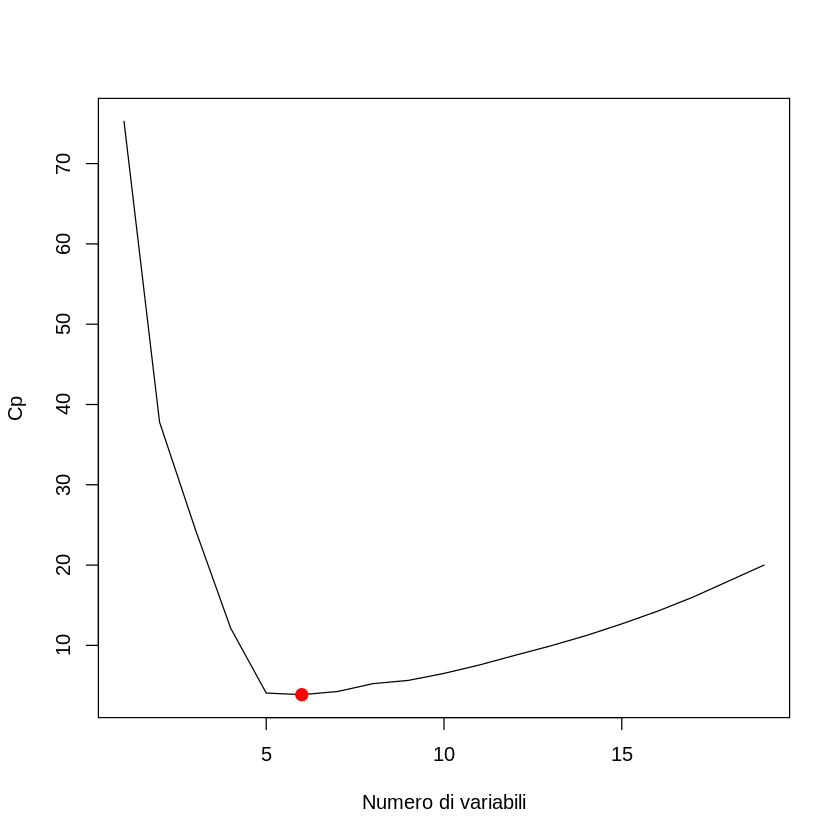

In [36]:
plot(reg.summary$cp,xlab="Numero di variabili",ylab="Cp",type='l')
nvar.bestsub <- which.min(reg.summary$cp)
points(nvar.bestsub,reg.summary$cp[nvar.bestsub],col="red",cex=2,pch=20)
bsub.pred <- predict(bsub.fit, newdata = df.scaled.test, id = nvar.bestsub)
bsub.MSE <- mean((bsub.pred - y.scaled.test) ^ 2)
bsub.MSE #MSE
bsub.coef <- coef(bsub.fit, nvar.bestsub)[- 1]

##  Regressione ridge

[1] 0.7156644

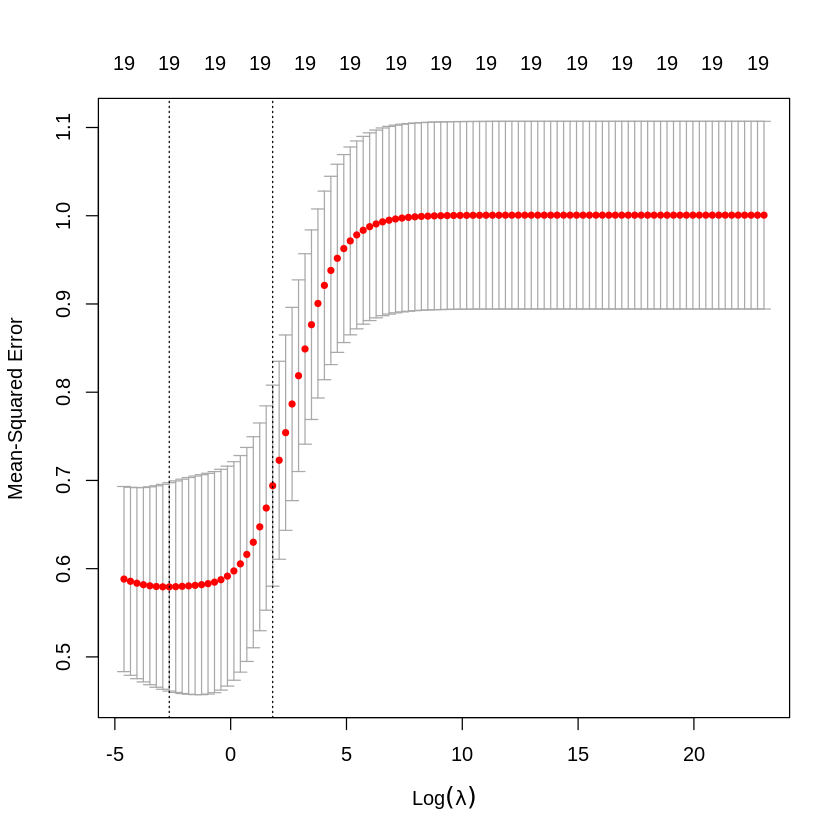

In [37]:
ridge.fit <- glmnet(x.scaled.train, y.scaled.train, alpha = 0, 
                    lambda = grid, standardize = FALSE)
set.seed(1)
cv.out <- cv.glmnet(x.scaled.train, y.scaled.train, alpha = 0, 
                    lambda = grid, standardize = FALSE) 
plot(cv.out)
ridge.bestlam <- cv.out$lambda.min
ridge.pred <- predict(ridge.fit, s = ridge.bestlam, newx = x.scaled.test)
ridge.MSE <- mean((ridge.pred - y.scaled.test) ^ 2)
ridge.MSE #MSE
ridge.coef <- predict(ridge.fit, type = "coefficients", 
                      s = ridge.bestlam)[- 1, ]

### Regressione LASSO

[1] 0.01

[1] 0.7455351

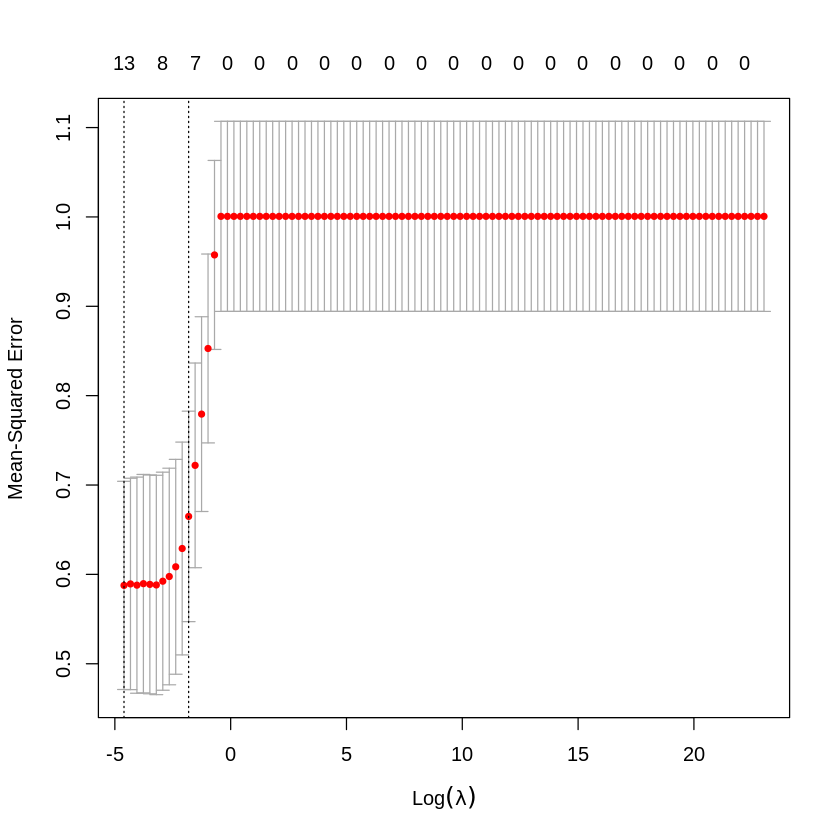

In [38]:
lasso.fit <- glmnet(x.scaled.train, y.scaled.train, alpha = 1, 
                    lambda = grid, standardize = FALSE)
set.seed(1)
cv.out <- cv.glmnet(x.scaled.train, y.scaled.train, alpha = 1, 
                    lambda = grid, standardize = FALSE) 
plot(cv.out)
lasso.bestlam <- cv.out$lambda.min
lasso.bestlam 
lasso.pred <- predict(lasso.fit, s = lasso.bestlam, newx = x.scaled.test)
lasso.MSE <- mean((lasso.pred - y.scaled.test) ^ 2)
lasso.MSE #MSE
lasso.coef <- predict(lasso.fit, type = "coefficients", 
                      s = lasso.bestlam)[- 1, ]

## Regressione PCR

[1] 0.7304746

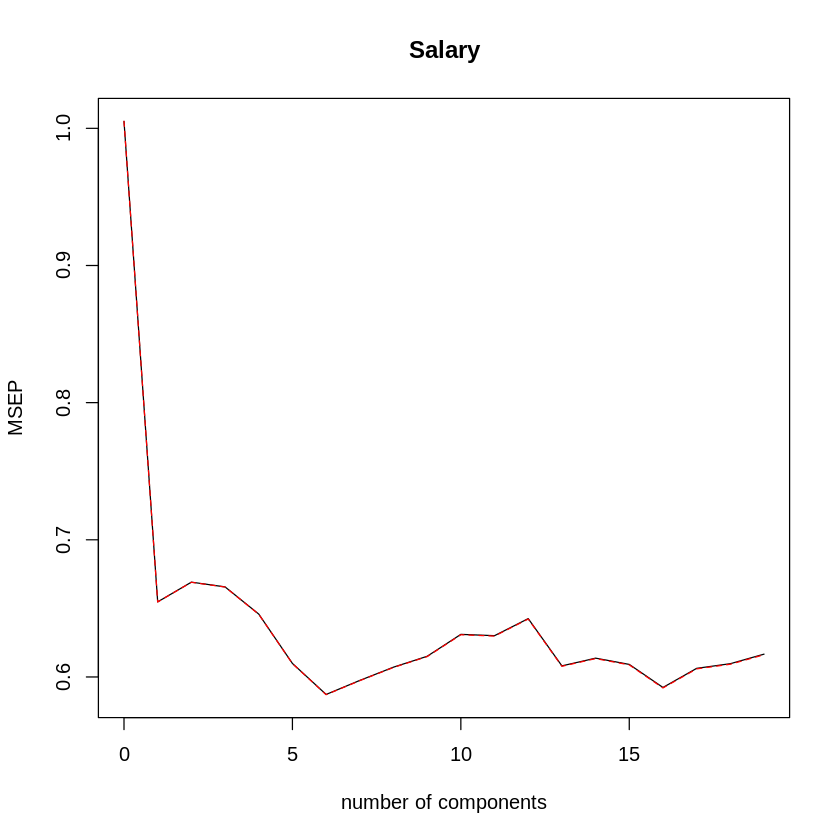

In [39]:
set.seed(1)
pcr.fit <- pcr(Salary ~ ., data = df.scaled.train, 
               scale = FALSE, validation = "LOO")
validationplot(pcr.fit, val.type = "MSEP")
pcr.ncomp <- which.min(pcr.fit$validation$PRESS)
pcr.pred <- predict(pcr.fit, df.scaled.test)[, , pcr.ncomp]
pcr.MSE <- mean((pcr.pred-y.scaled.test) ^ 2)
pcr.MSE #MSE
pcr.coef <- pcr.fit$coefficients[, , pcr.ncomp]

In realtà, il MSE non è un buon indicatore poiché può essere distorto da un numero basso di osservazioni nel test set. In sostituzione, risulta più efficace ispezionare gli errori di previsione, elevati al quadrato, in corrispondenza di ciascuna osservazione. Ad esempio è possibile fare un boxplot degli errori di previsione al quadrato.

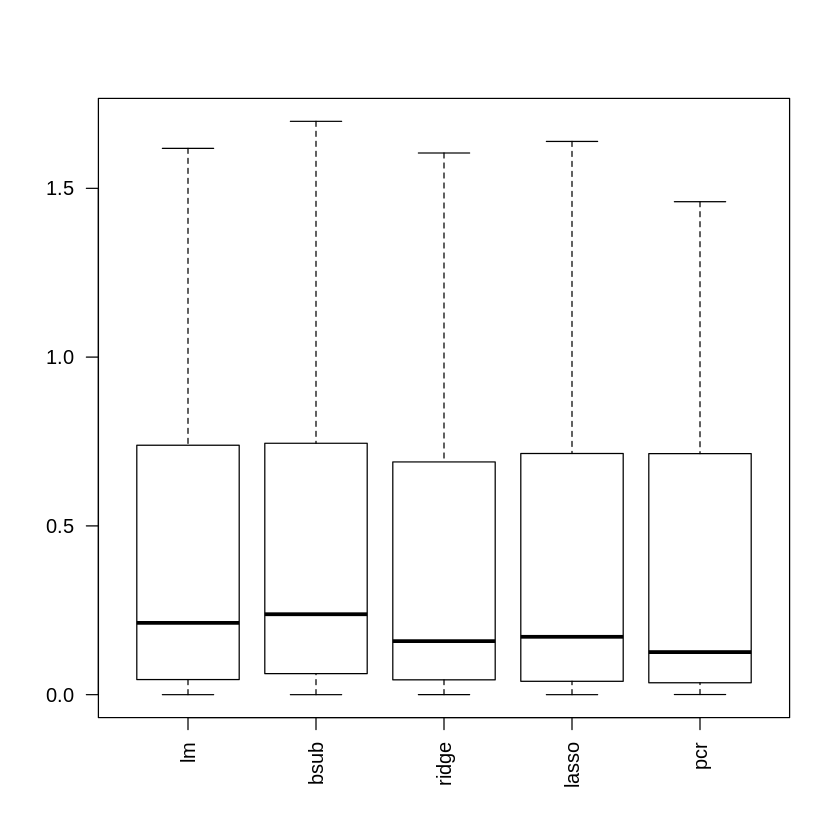

In [40]:
pred.err.df <- data.frame(
  lm = (lm.pred - y.scaled.test) ^ 2,
  bsub = (bsub.pred - y.scaled.test) ^ 2,
  ridge = as.numeric((ridge.pred - y.scaled.test) ^ 2),
  lasso = as.numeric((lasso.pred - y.scaled.test) ^ 2),
  pcr = (pcr.pred-y.scaled.test) ^ 2
)

boxplot(pred.err.df, las = 2, outline = FALSE)

Dai boxplot è difficile identificare il migliore metodo di previsione, ad esempio la regressione ridge e la PCR forniscono i valori più bassi per la mediana (ossia, il quantile 0.5). Tuttavia sembra che i risultati di tutti i metodi non siano molto differenti tra loro. 
Di seguito ti mostro le stime dei coefficienti di regressione ottenute attraverso i vari metodi.

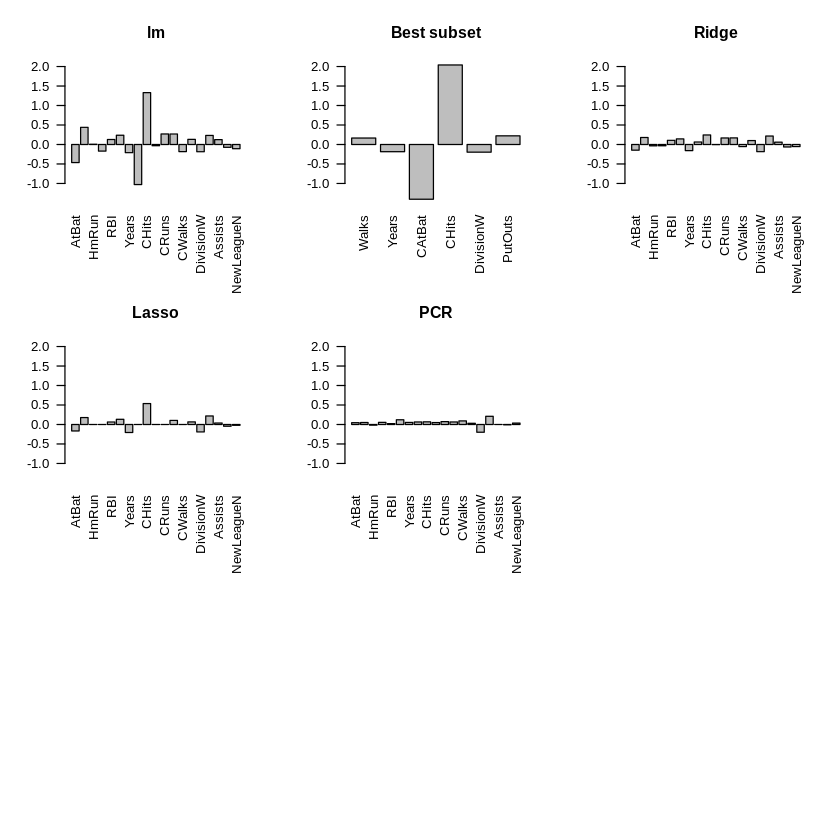

In [41]:
ylimits <- range(c(lm.coef, bsub.coef, ridge.coef, 
        lasso.coef, pcr.coef))
par(mfrow = c(3, 3))
barplot(lm.coef, main = "lm", las = 2, ylim = ylimits)
barplot(bsub.coef, main = "Best subset", las = 2, ylim = ylimits)
barplot(ridge.coef, main = "Ridge", las = 2, ylim = ylimits)
barplot(lasso.coef, main = "Lasso", las = 2, ylim = ylimits)
barplot(pcr.coef, main = "PCR", las = 2, ylim = ylimits)

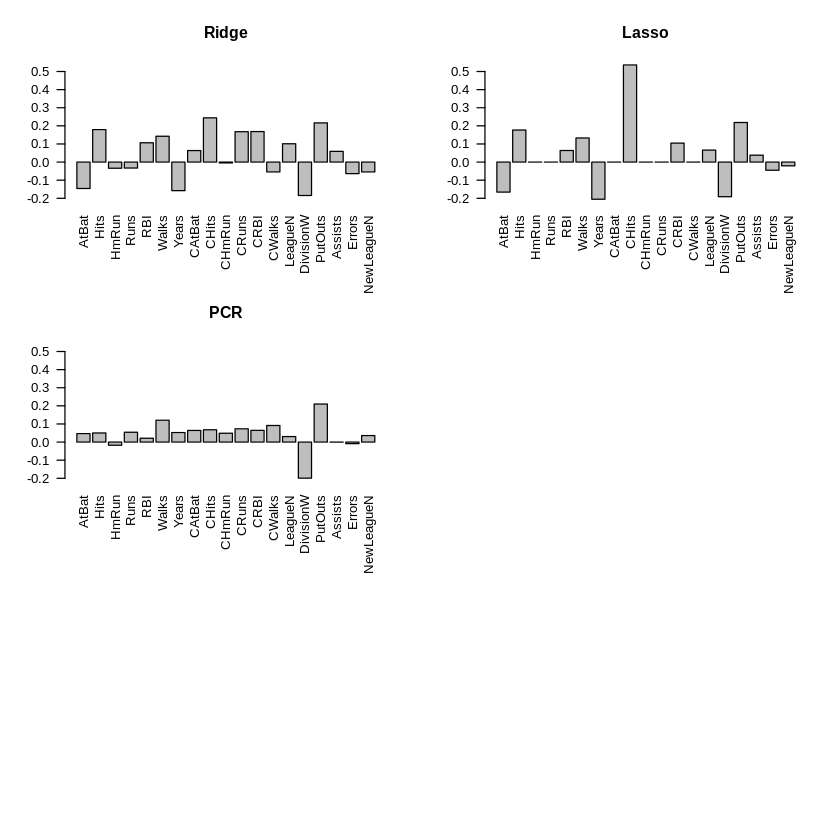

In [42]:
#Ripetiamo i grafici senza lm e bsub
ylimits <- range(c(ridge.coef, lasso.coef, pcr.coef))
par(mfrow = c(3, 2))
barplot(ridge.coef, main = "Ridge", las = 2, ylim = ylimits)
barplot(lasso.coef, main = "Lasso", las = 2, ylim = ylimits)
barplot(pcr.coef, main = "PCR", las = 2, ylim = ylimits)

Il valore MSE, calcolato sul test set, è direttamente collegato al valore di $R^2$.
Dal momento che sono simili, possiamo considerarne anche solo uno dei due.
Ad esempio, calcoliamo $R^2$ sul test set per il metodo di regressione LASSO.

In [43]:
R2test <- 1 - sum((lasso.pred - y.scaled.test) ^ 2) / 
  (sum((y.scaled.test - mean(y.scaled.train)) ^ 2))
round(R2test, 2)

[1] 0.43

Il vantaggio dell'indice $R^2$ rispetto al MSE è la maggiore interpretabilità.
$R^2$, valutato sul test set, è opportuno che assuma valori quanto più vicini possibili ad 1.
Nota comunque che, dal momento che è calcolato sul test set, $R^2$ non è vincolato ad assumere valori tra 0 ed 1. In particolare, può essere negativo se gli errori sul test set sono grandi. MSE può invece assumere solo valori positivi.

Complimenti! 
Se sei arrivato a questo punto, sei pronto per il prossimo Quiz!
In questa unità hai visto i più moderni metodi, alternativi alla regressione lineare multipla, allo scopo di mitigare i problemi di overfitting e multicollinearità.